In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate


In [82]:
#read in login data
data = pd.read_json('source_data/ultimate_data_challenge.json')

In [83]:
#inspect
data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [84]:
#details of DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [85]:
#let's see how many cities we have
data['city'].nunique(), data['city'].value_counts()

(3,
 Winterfell        23336
 Astapor           16534
 King's Landing    10130
 Name: city, dtype: int64)

In [86]:
#We should transform the date columns into true datetime objects for better utility
data['signup_date']=pd.to_datetime(data['signup_date'])
data['last_trip_date']=pd.to_datetime(data['last_trip_date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [87]:
#let's create a column for duration as a user and time since last ride. Using the latest last_trip_date as current date
data['user_days'] =  data['last_trip_date'].dt.dayofyear.max() - data['signup_date'].dt.dayofyear
data['days_since_last_trip'] = data['last_trip_date'].dt.dayofyear.max() - data['last_trip_date'].dt.dayofyear
data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  user_days  \
0         46.2      3.67                   5.0        157   
1         50.0      8.26                   5.0        153   
2        100.0      0.77                   5.0        176   
3         80.0      2.36                   4.9        172   
4         82.4      3.13                   4.9        155   

   days_since_last_trip  
0                    14  
1                    57  
2                   175  
3                     2  
4                   108

In [88]:
#we can use the new column to create an boolean active user column
data['active_user'] = data['days_since_last_trip'] <= 30
data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  user_days  \
0         46.2      3.67                   5.0        157   
1         50.0      8.26                   5.0        153   
2        100.0      0.77                   5.0        176   
3         80.0      2.36                   4.9        172   
4         82.4      3.13                   4.9        155   

   days_since_last_trip  active_user  
0                    14         True  
1                    57        False  
2                   175        False  
3                     2         True  
4                   108        False

In [89]:
data.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            50000.000000          41878.000000  50000.000000   
mean                 2.278200              4.601559      1.074764   
std                  3.792684              0.617338      0.222336   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.300000      1.000000   
50%                  1.000000              4.900000      1.000000   
75%                  3.000000              5.000000      1.050000   
max                125.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  \
count  50000.000000  50000.000000  50000.000000          49799.000000   
mean       8.849536     60.926084      5.796827              4.778158   
std       19.958811     37.081503      5.707357              0.446652   
min        0.000000      0.000000      0.000000              1.000000   
25%        0.000000     33.300000      2.420000              4.700000   
50%        0.000000     66.700000      3.880000              5.000000   
75%        8.600000    100.000000      6.940000              5.000000   
max      100.000000    100.000000    160.960000              5.000000   

         user_days  days_since_last_trip  
count  50000.00000          50000.000000  
mean     165.45532             72.665220  
std        8.75422             61.718985  
min      151.00000              0.000000  
25%      158.00000             13.000000  
50%      165.00000             54.000000  
75%      173.00000            137.000000  
max      181.00000            181.000000

Let's take a look at a heatmap of the correlations between features to see if any stand out.

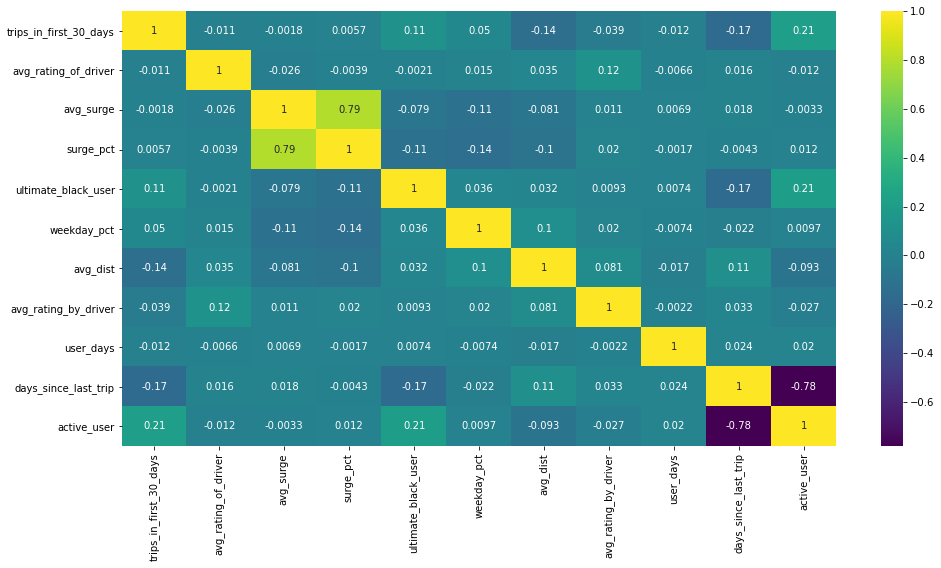

In [90]:
cr = data.corr()
plt.figure(figsize=(16,8))
sns.heatmap(cr, annot=True, cmap='viridis')
plt.show()

Nor suprisingly, the active_user column is well correlated to the days_since_last_trip column. THis is because the days_since_last_trip column were used to create it. We don't see many strong correlations. The avg_surge and surge_pct are correlated as the more often you use the service during a sruge the more likely you are going to have a hgiher avg_surge level. There does appear to be some week correlation between active_user and trips_in_first_30_days as well as ultimate_black_user. We'll investigate those further below.

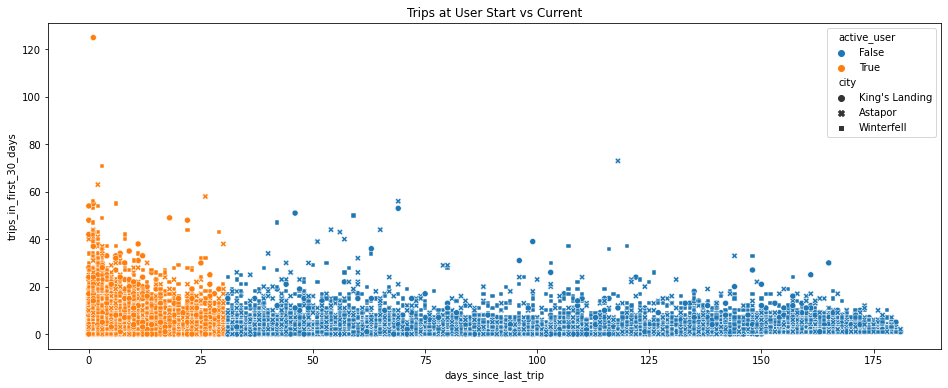

In [91]:
#Let's take a look at a plot for comparing trips at the start of user timeline vs more recently 
plt.figure(figsize=(16,6))
sns.scatterplot(data=data, hue = 'active_user', y='trips_in_first_30_days', x='days_since_last_trip', style='city')
plt.title('Trips at User Start vs Current')
plt.show()

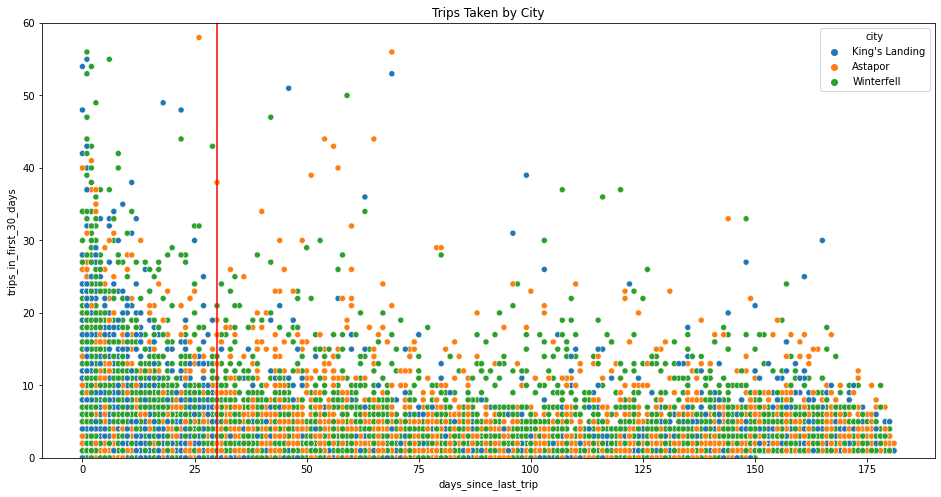

In [92]:
#It was difficult to see if the shapes representing the towns had a patterna above, let's try using color
#and we can add a vertical line for the break of active_users (left of line True, right of line False)
plt.figure(figsize=(16,8))
sns.scatterplot(data=data, hue = 'city', y='trips_in_first_30_days', x='days_since_last_trip')
plt.axvline(x=30, ls='-', label='30 trips', color='r')
plt.ylim((0,60))
plt.title('Trips Taken by City')
plt.show()

In the first graph there seems to be a small trend for active users having taken more trips in their first 30 days then non-active users. The second graph doesn't show a strong pattern, though Astapor (orange) is more heavily represented on the right of the line (non-active users).

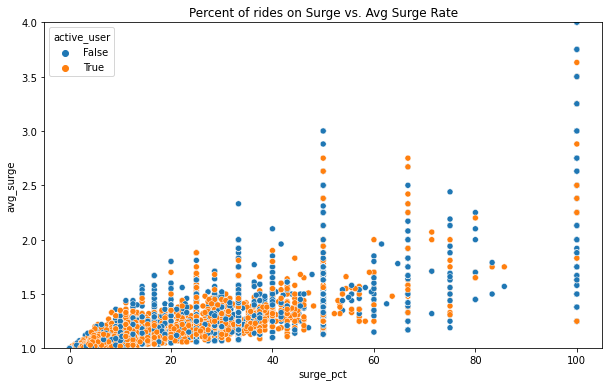

In [93]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data, hue = 'active_user', y='avg_surge', x='surge_pct')
plt.title('Percent of rides on Surge vs. Avg Surge Rate')
plt.ylim((1,4))
plt.show()

As expected from the heatmap, there isn't a discerable trend in the data for active users. The visual does follow our above reasoning that the lower a user's percent of use during surge, the less their avg surge rating.

In [94]:
#For easier inout into different models later on let's convert these boolean columns to numeric
data['ultimate_black_user'].replace({'True':1, 'False':0}, inplace=True)
data['ultimate_black_user'] = data['ultimate_black_user'].astype('int') 
data['active_user'].replace({'True':1, 'False':0}, inplace=True)
data['active_user'] = data['active_user'].astype('int') 
data['phone'].replace({'Android':1, 'iPhone':0}, inplace=True)
#data['phone'] = data['phone'].astype('int') 
#phone column has null values that need to be delat with be fore converting, see below
data.rename(columns={'phone':'android'}, inplace=True)
data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date  android  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17      0.0       15.4                    1   
1       1.00     2014-05-05      1.0        0.0                    0   
2       1.00     2014-01-07      0.0        0.0                    0   
3       1.14     2014-06-29      0.0       20.0                    1   
4       1.19     2014-03-15      1.0       11.8                    0   

   weekday_pct  avg_dist  avg_rating_by_driver  user_days  \
0         46.2      3.67                   5.0        157   
1         50.0      8.26                   5.0        153   
2        100.0      0.77                   5.0        176   
3         80.0      2.36                   4.9        172   
4         82.4      3.13                   4.9        155   

   days_since_last_trip  active_user  
0                    14            1  
1                    57            0  
2                   175            0  
3                     2            1  
4                   108            0

In [95]:
data['android'].unique()

array([ 0.,  1., nan])

In [96]:
#This is good time to fill in our null values
#we will use random to fill the android column and a mean rating to fill the driver and rider rating columns
data['android'].fillna(np.random.choice([0,1]), inplace=True)
data['avg_rating_of_driver'].fillna(data['avg_rating_of_driver'].mean(), inplace=True)
data['avg_rating_by_driver'].fillna(data['avg_rating_by_driver'].mean(), inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   android                 50000 non-null  float64       
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  user_days               50000 non-null  int64 

In [97]:
#Now we can convert the android column to numeric
data['android'] = data['android'].astype('int64') 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   android                 50000 non-null  int64         
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  user_days               50000 non-null  int64 

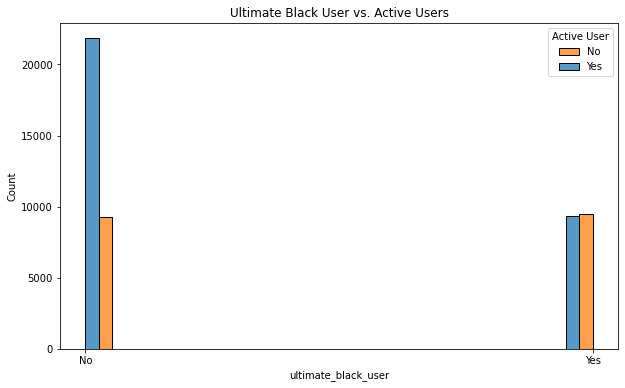

In [98]:
plt.figure(figsize=(10,6))
sns.histplot(data=data, hue = 'active_user', x='ultimate_black_user', multiple='dodge', legend='True')
plt.title('Ultimate Black User vs. Active Users')
plt.xticks([0,1], labels =['No', 'Yes'])
plt.legend(labels=['No', 'Yes'], title='Active User')
plt.show()

The above visual clearly shows that while approx. a third of non-Ultimate Black Users are active users, 50% of Ultimte Blakc Users are also active users. It would be interesting to see if they are more likely to become Ultimate Black Users because they were using the service often or if signing up for Ultimate Black Users made them more likely to use the service more often. We don't have timeline data on the Ultimate Black User sign-ups so can't say.

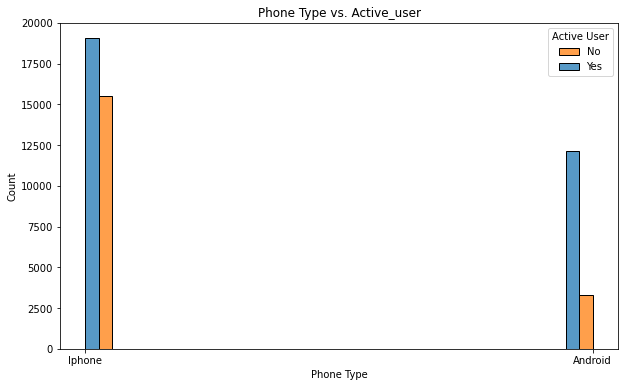

In [99]:
plt.figure(figsize=(10,6))
sns.histplot(data=data,  x='android', multiple='dodge', hue='active_user', legend='True')
plt.xticks([0,1], labels =['Iphone', 'Android'])
plt.xlabel('Phone Type')
plt.title('Phone Type vs. Active_user')
plt.legend(labels=['No', 'Yes'], title='Active User')
plt.show()

There does seem to be a correlation between iphone users and active users as the iphone users are about 40% active users and the android users are only 20-25%

In [100]:
data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date  android  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17        0       15.4                    1   
1       1.00     2014-05-05        1        0.0                    0   
2       1.00     2014-01-07        0        0.0                    0   
3       1.14     2014-06-29        0       20.0                    1   
4       1.19     2014-03-15        1       11.8                    0   

   weekday_pct  avg_dist  avg_rating_by_driver  user_days  \
0         46.2      3.67                   5.0        157   
1         50.0      8.26                   5.0        153   
2        100.0      0.77                   5.0        176   
3         80.0      2.36                   4.9        172   
4         82.4      3.13                   4.9        155   

   days_since_last_trip  active_user  
0                    14            1  
1                    57            0  
2                   175            0  
3                     2            1  
4                   108            0

In [131]:
data['avg_dist_bin'] = pd.qcut(data['avg_dist'], 10, labels=range(1,11))

In [132]:
data.groupby('avg_dist_bin')['active_user'].apply(lambda x:x.sum()/x.count()*100)

avg_dist_bin
1     22.379827
2     37.532598
3     44.781481
4     46.735395
5     47.263981
6     46.045029
7     41.128061
8     36.710631
9     31.731732
10    22.055288
Name: active_user, dtype: float64

In [122]:
data['active_user'].mean()

0.37608

In [148]:
data['user_days_bin'] = pd.qcut(data['user_days'], 10, labels=False)
data.groupby('user_days_bin')['active_user'].apply(lambda x:x.sum()/x.count()*100)

user_days_bin
0    36.566424
1    38.960371
2    36.503856
3    36.297671
4    35.942711
5    35.564054
6    36.718913
7    36.958970
8    43.389240
9    39.681335
Name: active_user, dtype: float64

In [138]:
data['user_days_bin'].unique().sort_values()

[(150.999, 154.0], (154.0, 157.0], (157.0, 159.0], (159.0, 163.0], (163.0, 165.0], (165.0, 168.0], (168.0, 171.0], (171.0, 175.0], (175.0, 178.0], (178.0, 181.0]]
Categories (10, interval[float64]): [(150.999, 154.0] < (154.0, 157.0] < (157.0, 159.0] < (159.0, 163.0] ... (168.0, 171.0] < (171.0, 175.0] < (175.0, 178.0] < (178.0, 181.0]]

In [147]:
bins1 = dict(enumerate(data['user_days_bin'].unique().sort_values(), start=1))
bins1                 

{1: '[',
 2: '(',
 3: '1',
 4: '5',
 5: '0',
 6: '.',
 7: '9',
 8: '9',
 9: '9',
 10: ',',
 11: ' ',
 12: '1',
 13: '5',
 14: '4',
 15: '.',
 16: '0',
 17: ']',
 18: ',',
 19: ' ',
 20: '(',
 21: '1',
 22: '5',
 23: '4',
 24: '.',
 25: '0',
 26: ',',
 27: ' ',
 28: '1',
 29: '5',
 30: '7',
 31: '.',
 32: '0',
 33: ']',
 34: ',',
 35: ' ',
 36: '(',
 37: '1',
 38: '5',
 39: '7',
 40: '.',
 41: '0',
 42: ',',
 43: ' ',
 44: '1',
 45: '5',
 46: '9',
 47: '.',
 48: '0',
 49: ']',
 50: ',',
 51: ' ',
 52: '(',
 53: '1',
 54: '5',
 55: '9',
 56: '.',
 57: '0',
 58: ',',
 59: ' ',
 60: '1',
 61: '6',
 62: '3',
 63: '.',
 64: '0',
 65: ']',
 66: ',',
 67: ' ',
 68: '(',
 69: '1',
 70: '6',
 71: '3',
 72: '.',
 73: '0',
 74: ',',
 75: ' ',
 76: '1',
 77: '6',
 78: '5',
 79: '.',
 80: '0',
 81: ']',
 82: ',',
 83: ' ',
 84: '(',
 85: '1',
 86: '6',
 87: '5',
 88: '.',
 89: '0',
 90: ',',
 91: ' ',
 92: '1',
 93: '6',
 94: '8',
 95: '.',
 96: '0',
 97: ']',
 98: ',',
 99: ' ',
 100: '(',
 101: '1

In [144]:
data['user_days_bin'].replace(bins1,inplace=True)

In [145]:
data['user_days_bin']

0          (154.0, 157.0]
1        (150.999, 154.0]
2          (175.0, 178.0]
3          (171.0, 175.0]
4          (154.0, 157.0]
               ...       
49995      (154.0, 157.0]
49996      (157.0, 159.0]
49997    (150.999, 154.0]
49998      (165.0, 168.0]
49999      (163.0, 165.0]
Name: user_days_bin, Length: 50000, dtype: category
Categories (10, interval[float64]): [(150.999, 154.0] < (154.0, 157.0] < (157.0, 159.0] < (159.0, 163.0] ... (168.0, 171.0] < (171.0, 175.0] < (175.0, 178.0] < (178.0, 181.0]]

In [125]:
data['weekday_pct_bin'] = pd.qcut(data['weekday_pct'], 10, duplicates='drop')
data.groupby('weekday_pct_bin')['active_user'].apply(lambda x:x.sum()/x.count()*100)

wd_bin
(-0.001, 20.0]    20.475719
(20.0, 44.4]      54.001585
(44.4, 52.6]      42.942142
(52.6, 66.7]      60.909539
(66.7, 80.0]      64.489523
(80.0, 100.0]     27.386533
Name: active_user, dtype: float64

In [129]:
data_bool = data[['android', 'ultimate_black_user', 'active_user']]
data_num = data[['trips_in_first_30_days', 'avg_rating_of_driver','avg_surge', 'surge_pct','weekday_pct', 'avg_dist',
                 'avg_rating_by_driver', 'user_days']]#, 'days_since_last_trip']]
data_cat = data[['city', 'wd_bin', 'days_bin', 'avg_dist_bin']]

In [130]:
data_cat = pd.get_dummies(data_cat)
data_cat

city_Astapor  city_King's Landing  city_Winterfell  \
0                 0                    1                0   
1                 1                    0                0   
2                 1                    0                0   
3                 0                    1                0   
4                 0                    0                1   
...             ...                  ...              ...   
49995             0                    1                0   
49996             1                    0                0   
49997             0                    0                1   
49998             1                    0                0   
49999             1                    0                0   

       wd_bin_(-0.001, 20.0]  wd_bin_(20.0, 44.4]  wd_bin_(44.4, 52.6]  \
0                          0                    0                    1   
1                          0                    0                    1   
2                          0                    0                    0   
3                          0                    0                    0   
4                          0                    0                    0   
...                      ...                  ...                  ...   
49995                      0                    0                    0   
49996                      1                    0                    0   
49997                      0                    0                    0   
49998                      0                    0                    0   
49999                      1                    0                    0   

       wd_bin_(52.6, 66.7]  wd_bin_(66.7, 80.0]  wd_bin_(80.0, 100.0]  \
0                        0                    0                     0   
1                        0                    0                     0   
2                        0                    0                     1   
3                        0                    1                     0   
4                        0                    0                     1   
...                    ...                  ...                   ...   
49995                    0                    0                     1   
49996                    0                    0                     0   
49997                    0                    0                     1   
49998                    0                    0                     1   
49999                    0                    0                     0   

       days_bin_(150.999, 154.0]  ...  avg_dist_bin_(-0.001, 1.59]  \
0                              0  ...                            0   
1                              1  ...                            0   
2                              0  ...                            1   
3                              0  ...                            0   
4                              0  ...                            0   
...                          ...  ...                          ...   
49995                          0  ...                            0   
49996                          0  ...                            1   
49997                          1  ...                            0   
49998                          0  ...                            0   
49999                          0  ...                            0   

       avg_dist_bin_(1.59, 2.17]  avg_dist_bin_(2.17, 2.68]  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          1   
4                              0                          0   
...                          ...                        ...   
49995                          0                          0   
49996                          0                          0   
49997                          0                          0   
49998                          0     

In [103]:
scaler= StandardScaler()
data_num_trans = scaler.fit_transform(data_num)
data_num_df = pd.DataFrame(data_num_trans)

In [104]:
model_data = pd.concat([data_bool, data_num, data_cat], axis=1)

In [105]:
col_rn = dict(zip(data_num_df.columns, data_num.columns))

In [106]:
model_data.rename(columns=col_rn, inplace=True)
model_data.head()

android  ultimate_black_user  active_user  trips_in_first_30_days  \
0        0                    1            1                       4   
1        1                    0            0                       0   
2        0                    0            0                       3   
3        0                    1            1                       9   
4        1                    0            0                      14   

   avg_rating_of_driver  avg_surge  surge_pct  weekday_pct  avg_dist  \
0                   4.7       1.10       15.4         46.2      3.67   
1                   5.0       1.00        0.0         50.0      8.26   
2                   4.3       1.00        0.0        100.0      0.77   
3                   4.6       1.14       20.0         80.0      2.36   
4                   4.4       1.19       11.8         82.4      3.13   

   avg_rating_by_driver  user_days  Astapor  King's Landing  Winterfell  
0                   5.0        157        0               1           0  
1                   5.0        153        1               0           0  
2                   5.0        176        1               0           0  
3                   4.9        172        0               1           0  
4                   4.9        155        0               0           1

In [107]:
X_train, X_test, y_train, y_test = train_test_split(model_data.drop(columns=['active_user']), model_data['active_user'],
                                                   test_size=0.33, random_state=42)

In [108]:
logistic = LogisticRegressionCV(solver='liblinear', penalty='l1', cv=5)
logistic.fit(X_train, y_train)
logistic.score(X_test, y_test)

0.7183636363636363

In [117]:
logistic.coef_

array([[-1.07343311e+00,  8.73454110e-01,  1.24127809e-01,
        -4.02477129e-02, -1.99544690e-01,  4.36054503e-03,
        -1.90754286e-04, -3.46906215e-02, -1.39958478e-01,
         6.31821371e-03, -9.19724581e-01,  8.02861886e-01,
        -3.92630299e-01]])

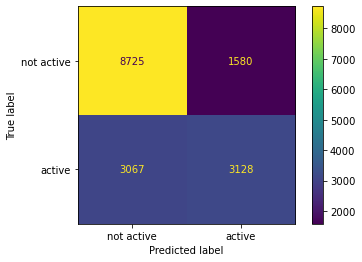

In [118]:
y_pred = logistic.predict(X_test)
cf = confusion_matrix(y_test, y_pred, labels=logistic.classes_)
disp = ConfusionMatrixDisplay(cf, display_labels=['not active','active'])
disp.plot()
plt.show()

In [119]:
coefficients = pd.DataFrame(abs(logistic.coef_), columns=model_data.drop(columns=['active_user']).columns, index=['coefficent'])
coefficients.T.sort_values(by='coefficent', ascending=False)

coefficent
android                   1.073433
Astapor                   0.919725
ultimate_black_user       0.873454
King's Landing            0.802862
Winterfell                0.392630
avg_surge                 0.199545
avg_rating_by_driver      0.139958
trips_in_first_30_days    0.124128
avg_rating_of_driver      0.040248
avg_dist                  0.034691
user_days                 0.006318
surge_pct                 0.004361
weekday_pct               0.000191

<Figure size 1152x576 with 0 Axes>

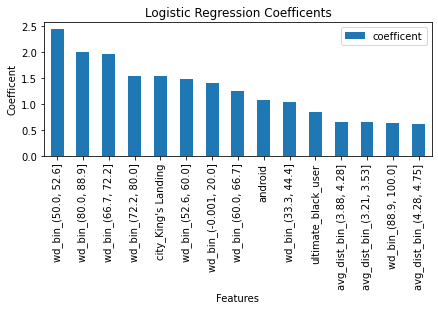

In [75]:
plt.figure(figsize=(16, 8))
coefficients.T.sort_values(by='coefficent', ascending=False).head(15).plot(kind='bar')
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Logistic Regression Coefficents')
plt.xlabel('Features')
plt.ylabel('Coefficent')
plt.show()

In [78]:
kfold = KFold(n_splits=5)

In [80]:
rf = RandomForestClassifier()
#rf.fit(X_train, y_train)
cvalrf = cross_validate(rf, model_data.drop(columns=['active_user']), model_data['active_user'], cv=kfold, scoring='accuracy')
cvalrf

{'fit_time': array([9.70039916, 9.79494691, 9.79020619, 9.7303071 , 9.98269892]),
 'score_time': array([0.36400008, 0.36100149, 0.36700583, 0.36405444, 0.36599922]),
 'test_score': array([0.7773, 0.7705, 0.7708, 0.7775, 0.784 ])}

In [63]:
importances = pd.DataFrame(rf.feature_importances_, index=model_data.drop(columns=['active_user']).columns, columns=['importance'])
importances.sort_values(by='importance', ascending=False).head(15)

importance
avg_dist                  0.110372
avg_rating_by_driver      0.081019
weekday_pct               0.077835
user_days                 0.061579
trips_in_first_30_days    0.060261
surge_pct                 0.058328
avg_rating_of_driver      0.054808
avg_surge                 0.045011
city_King's Landing       0.043636
android                   0.035453
ultimate_black_user       0.032166
city_Astapor              0.018844
wd_bin_(-0.001, 20.0]     0.017352
wd_bin_(88.9, 100.0]      0.014934
city_Winterfell           0.014351

<Figure size 1152x576 with 0 Axes>

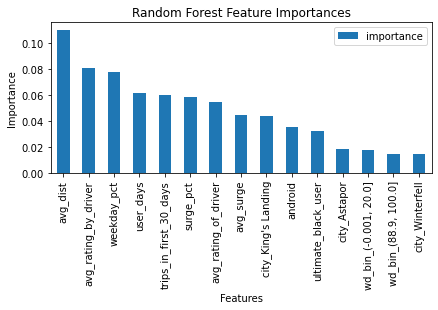

In [65]:
plt.figure(figsize=(16, 8))
importances.sort_values(by='importance', ascending=False).head(15).plot(kind='bar')
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

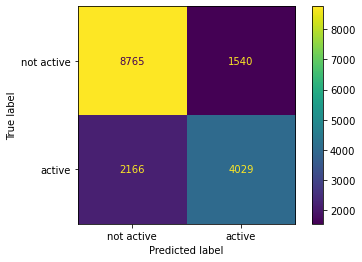

In [66]:
y_pred = rf.predict(X_test)
cf = confusion_matrix(y_test, y_pred, labels=logistic.classes_)
disp = ConfusionMatrixDisplay(cf, display_labels=['not active','active'])
disp.plot()
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit()

In [44]:
paramsrf={'n_estimators':[5, 10, 50, 100, 150, 200], 'criterion':['gini', 'entropy'], 'max_depth':[1, 2, 4, 8, 16]}
randrf = RandomizedSearchCV(rf, param_distributions=paramsrf, cv=5)

In [47]:
randrf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 4, 8, 16],
                                        'n_estimators': [5, 10, 50, 100, 150,
                                                         200]})

In [49]:
randrf.cv_results_

{'mean_fit_time': array([1.43684559, 0.49381218, 0.13158979, 3.77598991, 4.53397117,
        4.88056836, 1.94708276, 1.09326105, 7.52681408, 0.77667484]),
 'std_fit_time': array([0.02144893, 0.02157753, 0.00336202, 0.03148893, 0.05418101,
        0.04232838, 0.05171252, 0.03959775, 0.25721517, 0.01174353]),
 'mean_score_time': array([0.10121946, 0.02659907, 0.01340551, 0.14741335, 0.1912199 ,
        0.18820105, 0.11298952, 0.07779751, 0.28059015, 0.03960514]),
 'std_score_time': array([0.0009655 , 0.00046779, 0.00050891, 0.00453829, 0.00800207,
        0.00298687, 0.00168541, 0.00161194, 0.00698841, 0.00080571]),
 'param_n_estimators': masked_array(data=[200, 10, 10, 150, 100, 100, 200, 150, 150, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[1, 16, 2, 8, 16, 16, 2, 1, 16, 4],
              mask=[False, False, False, False, Fal

In [51]:
randrf.best_estimator_

RandomForestClassifier(max_depth=16)

In [52]:
rf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7807878787878788

In [53]:
randrf.score(X_test, y_test)

0.7830909090909091

In [54]:
paramslog = {'solver':['saga'], 'penalty':['elasticnet'], 'C':[0.1, 0.3, 0.5, 1],#2, 5, 10, 20], 
             'l1_ratio':[0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'max_iter':[500]}
gridlog = GridSearchCV(logistic, param_grid=paramslog, cv=5)

In [55]:
gridlog.fit(X_train, y_train)

C:\Users\bwils\anaconda3\envs\takehome\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\bwils\anaconda3\envs\takehome\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\bwils\anaconda3\envs\takehome\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\bwils\anaconda3\envs\takehome\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\bwils\anaconda3\envs\takehome\lib\site-packages\sklearn\linear_mode

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.3, 0.5, 1],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1],
                         'max_iter': [500], 'penalty': ['elasticnet'],
                         'solver': ['saga']})

In [56]:
gridlog.best_estimator_

LogisticRegression(C=0.3, l1_ratio=0.8, max_iter=500, penalty='elasticnet',
                   solver='saga')

In [57]:
gridlog.best_score_

0.7587761194029851

In [58]:
data['last_trip_date'].describe(datetime_is_numeric=True)

count                            50000
mean     2014-04-19 08:02:04.992000256
min                2014-01-01 00:00:00
25%                2014-02-14 00:00:00
50%                2014-05-08 00:00:00
75%                2014-06-18 00:00:00
max                2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [59]:
data['user_days'].describe()

count    50000.00000
mean       165.45532
std          8.75422
min        151.00000
25%        158.00000
50%        165.00000
75%        173.00000
max        181.00000
Name: user_days, dtype: float64

In [60]:
rf_pred = pd.DataFrame(randrf.predict(X_test), columns=['prediction'], index=X_test.index)
y_test_df = pd.DataFrame(y_test, columns=['active_user'])
evalu = pd.concat([X_test, y_test_df, rf_pred], axis=1)
#evalu.insert(0, value=rf_pred, column='prediction')

In [61]:
evalu

android  ultimate_black_user  trips_in_first_30_days  \
33553        0                    1               -0.337021   
9427         0                    1               -0.600689   
199          0                    0               -0.600689   
12447        1                    0               -0.073352   
39489        1                    0               -0.600689   
...        ...                  ...                     ...   
27615        0                    0               -0.600689   
21964        0                    0               -0.073352   
33321        0                    0               -0.600689   
40225        0                    1               -0.337021   
28203        0                    0                0.190316   

       avg_rating_of_driver  avg_surge  surge_pct  weekday_pct  avg_dist  \
33553             -1.418762  -0.336268  -0.443394    -0.024975 -0.416454   
9427               0.351241  -0.336268  -0.443394     0.379544 -0.453249   
199                0.705241  -0.336268  -0.443394     1.053741 -0.213205   
12447              0.705241   1.912603   2.061790    -1.643048 -0.500557   
39489              0.351241  -0.201336   0.112757    -0.143633 -0.535599   
...                     ...        ...        ...          ...       ...   
27615              0.000000  -0.336268  -0.443394     1.053741  3.112360   
21964              0.000000  -0.336268  -0.443394     1.053741  0.168762   
33321              0.528241  -0.156359  -0.087658    -0.871766 -0.526839   
40225              0.000000  -0.336268  -0.443394    -1.643048  0.298420   
28203              0.705241  -0.336268  -0.443394     0.155710  0.240599   

       avg_rating_by_driver  user_days  ...  avg_dist_bin_(4.75, 5.32]  \
33553             -0.175341   0.747610  ...                          0   
9427               0.497684   0.176452  ...                          0   
199                0.497684   0.062220  ...                          0   
12447              0.497684  -1.194330  ...                          0   
39489              0.049000   1.318769  ...                          0   
...                     ...        ...  ...                        ...   
27615              0.497684   1.433001  ...                          0   
21964              0.497684   0.062220  ...                          0   
33321              0.497684   0.976074  ...                          0   
40225              0.497684  -0.965866  ...                          0   
28203             -0.175341   1.433001  ...                          0   

       avg_dist_bin_(5.32, 6.01]  avg_dist_bin_(6.01, 6.94]  \
33553                          0                          0   
9427                           0                          0   
199                            0                          0   
12447                          0                          0   
39489                          0                          0   
...                          ...                        ...   
27615                          0                          0   
21964                          0                          1   
33321                          0                          0   
40225                          0                          0   
28203                          0                          0   

       avg_dist_bin_(6.94, 8.18]  avg_dist_bin_(8.18, 10.07]  \
33553                          0                           0   
9427                           0                           0   
199                            0                           0   
12447                          0                           0   
39489                          0                           0   
...                          ...                         ...   
27615                          0                           0   
21964                          0                           0   
33321                          0                           0   
40225                          1                   

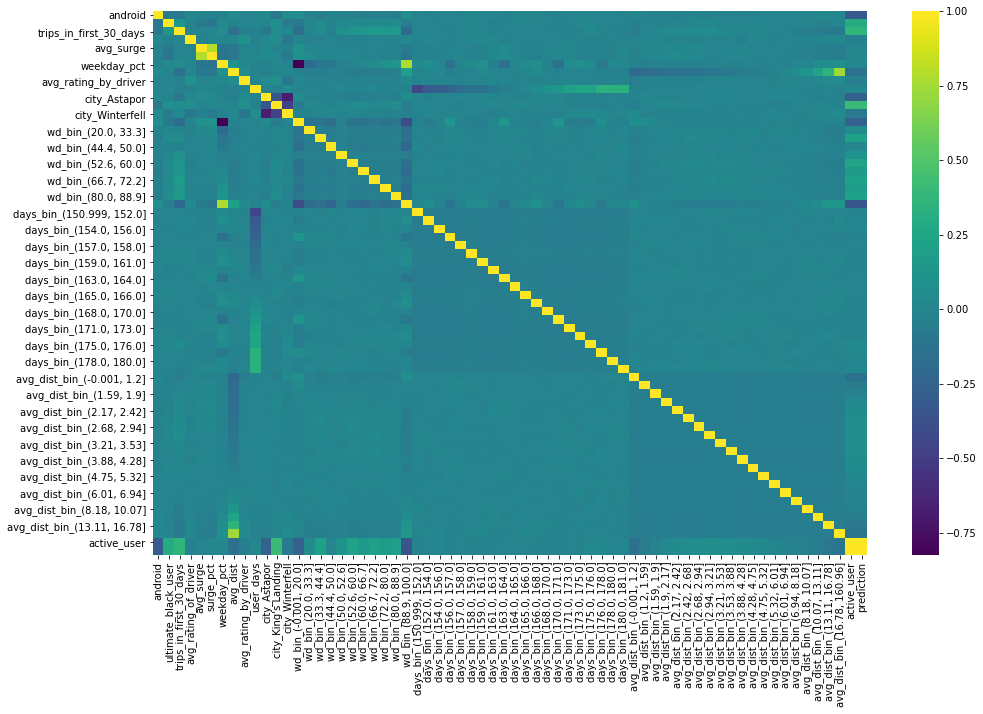

In [73]:
rfcorr = evalu.loc[evalu['active_user']==evalu['prediction']].corr()
plt.figure(figsize=(16,10))
sns.heatmap(rfcorr, cmap='viridis')
plt.show()

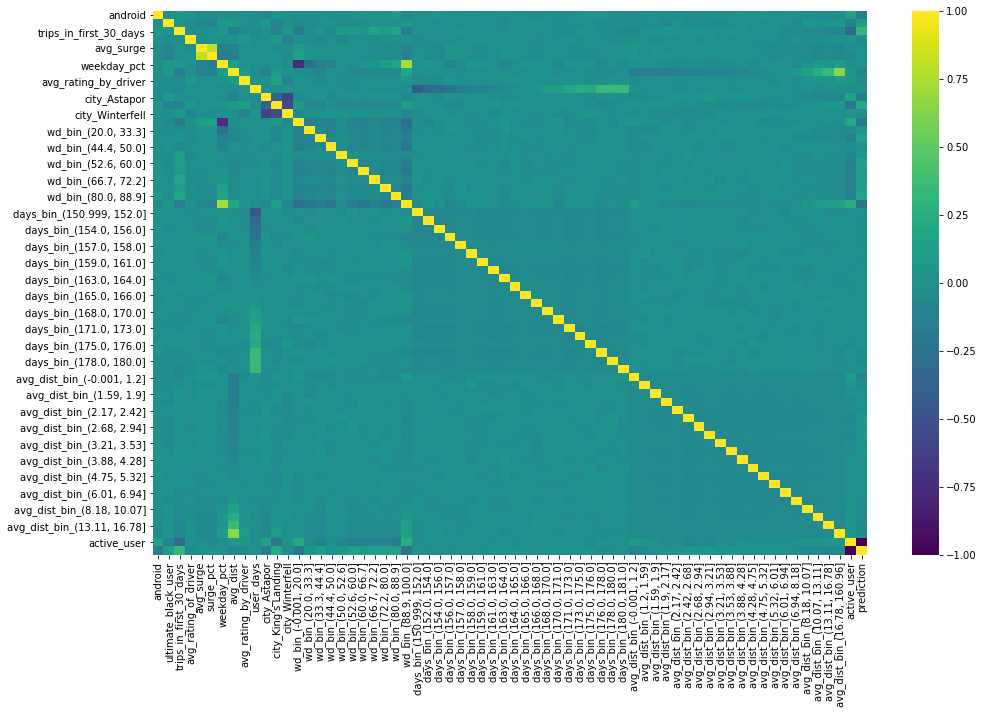

In [72]:
rfcorr = evalu.loc[evalu['active_user']!=evalu['prediction']].corr()
plt.figure(figsize=(16,10))
sns.heatmap(rfcorr, cmap='viridis')
plt.show()

In [64]:
from sklearn.ensemble import AdaBoostClassifier

In [65]:
ada = AdaBoostClassifier(RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=50))

In [66]:
ada.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         max_depth=8,
                                                         n_estimators=50))

In [67]:
ada.score(X_test, y_test)

0.780969696969697

In [68]:
ada.estimator_errors_

array([0.21098507, 0.34520692, 0.36040226, 0.33059802, 0.32245678,
       0.30677349, 0.30745307, 0.32197576, 0.31116105, 0.3280896 ,
       0.31478989, 0.32782936, 0.32183623, 0.31254678, 0.32958986,
       0.32179676, 0.32630028, 0.31369416, 0.32064073, 0.32157796,
       0.31837377, 0.3265421 , 0.32490745, 0.32121206, 0.31910782,
       0.32081503, 0.32290723, 0.31705068, 0.32415392, 0.32213921,
       0.32763566, 0.33012368, 0.32578639, 0.33012954, 0.32098927,
       0.32328683, 0.32393365, 0.32302103, 0.32489637, 0.32844083,
       0.32690254, 0.32605491, 0.32343383, 0.32923717, 0.32734236,
       0.32612693, 0.33320311, 0.33362083, 0.3255386 , 0.33034559])

In [69]:
importancesada = pd.DataFrame(ada.feature_importances_, index=model_data.drop(columns=['active_user']).columns, columns=['importanceada'])
importancesada.sort_values(by='importanceada', ascending=False)

importanceada
avg_dist                           0.134817
trips_in_first_30_days             0.072869
weekday_pct                        0.070345
avg_rating_of_driver               0.069156
avg_rating_by_driver               0.063202
...                                     ...
avg_dist_bin_(13.11, 16.78]        0.005263
avg_dist_bin_(-0.001, 1.2]         0.004679
days_bin_(180.0, 181.0]            0.004481
avg_dist_bin_(16.78, 160.96]       0.004020
wd_bin_(50.0, 52.6]                0.001525

[64 rows x 1 columns]

In [70]:
pd.concat([importances.T, importancesada.T, coefficients]).T.sort_values(by='importance', ascending=False).head(20)

importance  importanceada  coefficent
avg_dist                     0.109663       0.134817    0.074479
avg_rating_by_driver         0.079483       0.063202    0.065049
weekday_pct                  0.074555       0.070345    0.593865
trips_in_first_30_days       0.063370       0.072869    0.148640
user_days                    0.061855       0.055349    0.012902
surge_pct                    0.056291       0.056580    0.068408
avg_rating_of_driver         0.054801       0.069156    0.007180
avg_surge                    0.053833       0.054082    0.017322
city_King's Landing          0.042186       0.019533    1.068841
android                      0.035454       0.023659    1.072693
ultimate_black_user          0.031195       0.022502    0.829246
city_Astapor                 0.019550       0.018227    0.782964
wd_bin_(88.9, 100.0]         0.015362       0.011173    0.545926
wd_bin_(-0.001, 20.0]        0.014751       0.010226    2.259688
city_Winterfell              0.013348       0.016707    0.222698
days_bin_(171.0, 173.0]      0.007518       0.007272    0.077449
avg_dist_bin_(4.75, 5.32]    0.007010       0.006490    0.245566
avg_dist_bin_(3.88, 4.28]    0.006819       0.005676    0.350640
days_bin_(161.0, 163.0]      0.006730       0.006914    0.135244
avg_dist_bin_(4.28, 4.75]    0.006703       0.006670    0.316754

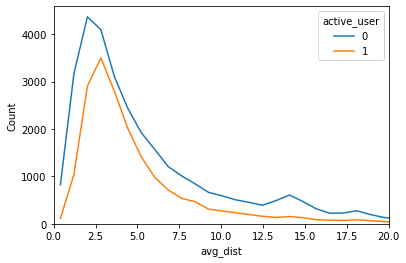

In [71]:
sns.histplot(data=data, x='avg_dist', hue='active_user', element='poly', fill=False, bins=200)
plt.xlim((0,20))
plt.show()